# Postprocessing

Here we analyze the modelling results.

In [1]:
import pandas as pd

INPUT_DIR = os.path.abspath('data')
WORKING_DIR = os.path.abspath("data/working")

## Python Solution

In [ ]:
results = pd.read_parquet(f'{WORKING_DIR}/model_search.parquet')
best_models = results.sort_values('metric', ascending=True).groupby("unique_id").first()
best_models['models'].value_counts()

In [2]:
from fugue_notebook import setup
setup()

<IPython.core.display.Javascript object>

In [4]:
%%fsql
results = LOAD '{{WORKING_DIR}}/model_search.parquet'
PRINT

,models,metric,unique_id
0,CrostonClassic,1.279644,HOBBIES_1_001_CA_1_evaluation
1,IMAPA,1.123630,HOBBIES_1_001_CA_1_evaluation
2,AutoARIMA,1.107207,HOBBIES_1_001_CA_1_evaluation
3,CrostonClassic,0.930472,HOBBIES_1_002_CA_1_evaluation
4,IMAPA,0.330838,HOBBIES_1_002_CA_1_evaluation
5,AutoARIMA,0.408934,HOBBIES_1_002_CA_1_evaluation
6,CrostonClassic,0.956045,HOBBIES_1_003_CA_1_evaluation
7,IMAPA,0.806460,HOBBIES_1_003_CA_1_evaluation
8,AutoARIMA,0.807030,HOBBIES_1_003_CA_1_evaluation
9,CrostonClassic,1.952671,HOBBIES_1_004_CA_1_evaluation


In [7]:
%%fsql
results = LOAD '{{WORKING_DIR}}/model_search.parquet'

temp = SELECT models, metric, unique_id,
       ROW_NUMBER() OVER (PARTITION BY unique_id ORDER BY metric ASC) AS ranked_order
       FROM results

SELECT *
  FROM temp
 WHERE ranked_order = 1 
 PRINT

ANTLR runtime and generated code versions disagree: 4.11.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.11.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.11.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.11.1!=4.10.1


,models,metric,unique_id,ranked_order
0,AutoARIMA,0.116100,HOBBIES_1_018_CA_1_evaluation,1
1,IMAPA,0.121229,HOBBIES_1_011_CA_1_evaluation,1
2,IMAPA,0.173060,HOBBIES_1_035_CA_1_evaluation,1
3,AutoARIMA,0.192589,HOBBIES_1_039_CA_1_evaluation,1
4,IMAPA,0.256529,HOBBIES_1_020_CA_1_evaluation,1
5,IMAPA,0.278753,HOBBIES_1_026_CA_1_evaluation,1
6,IMAPA,0.291273,HOBBIES_1_031_CA_1_evaluation,1
7,IMAPA,0.292980,HOBBIES_1_024_CA_1_evaluation,1
8,IMAPA,0.330838,HOBBIES_1_002_CA_1_evaluation,1
9,AutoARIMA,0.336962,HOBBIES_1_012_CA_1_evaluation,1


## Anonymity

We can simplify the code further by removing the temp table. The next query will just operate on the result of the previous query.

In [9]:
%%fsql
results = LOAD '{{WORKING_DIR}}/model_search.parquet'

SELECT models, metric, unique_id,
ROW_NUMBER() OVER (PARTITION BY unique_id ORDER BY metric ASC) AS ranked_order

SELECT *
 WHERE ranked_order = 1 
 PRINT

ANTLR runtime and generated code versions disagree: 4.11.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.11.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.11.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.11.1!=4.10.1


,models,metric,unique_id,ranked_order
0,AutoARIMA,0.116100,HOBBIES_1_018_CA_1_evaluation,1
1,IMAPA,0.121229,HOBBIES_1_011_CA_1_evaluation,1
2,IMAPA,0.173060,HOBBIES_1_035_CA_1_evaluation,1
3,AutoARIMA,0.192589,HOBBIES_1_039_CA_1_evaluation,1
4,IMAPA,0.256529,HOBBIES_1_020_CA_1_evaluation,1
5,IMAPA,0.278753,HOBBIES_1_026_CA_1_evaluation,1
6,IMAPA,0.291273,HOBBIES_1_031_CA_1_evaluation,1
7,IMAPA,0.292980,HOBBIES_1_024_CA_1_evaluation,1
8,IMAPA,0.330838,HOBBIES_1_002_CA_1_evaluation,1
9,AutoARIMA,0.336962,HOBBIES_1_012_CA_1_evaluation,1


## Additional Keywords

We can further simplify the query above by using additional `FugueSQL` keywords.

In [12]:
%%fsql
results = LOAD '{{WORKING_DIR}}/model_search.parquet'

TAKE 1 ROW PREPARTITION BY unique_id PRESORT metric ASC
PRINT

,models,metric,unique_id
0,AutoARIMA,0.116100,HOBBIES_1_018_CA_1_evaluation
1,IMAPA,0.121229,HOBBIES_1_011_CA_1_evaluation
2,IMAPA,0.173060,HOBBIES_1_035_CA_1_evaluation
3,AutoARIMA,0.192589,HOBBIES_1_039_CA_1_evaluation
4,IMAPA,0.256529,HOBBIES_1_020_CA_1_evaluation
5,IMAPA,0.278753,HOBBIES_1_026_CA_1_evaluation
6,IMAPA,0.291273,HOBBIES_1_031_CA_1_evaluation
7,IMAPA,0.292980,HOBBIES_1_024_CA_1_evaluation
8,IMAPA,0.330838,HOBBIES_1_002_CA_1_evaluation
9,AutoARIMA,0.336962,HOBBIES_1_012_CA_1_evaluation


## Python Interoperability

In [46]:
%%fsql spark
results = LOAD '{{WORKING_DIR}}/model_search.parquet'

TAKE 1 ROW PREPARTITION BY unique_id PRESORT metric ASC
YIELD DATAFRAME AS top

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/16 02:39:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/16 02:39:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [47]:
top = top.native.toPandas()

In [48]:
top['models'].value_counts()

IMAPA             29
AutoARIMA         20
CrostonClassic     1
Name: models, dtype: int64

In [43]:
import seaborn as sns

def plotter(df: pd.DataFrame):
    sns.countplot(x=df['models'])
    return

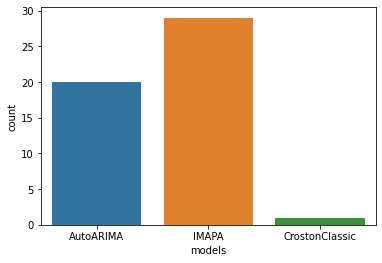

In [44]:
plotter(top)

## Interoperable SQL and Python

We can actually compress the previous steps by invoking Python in `FugueSQL`

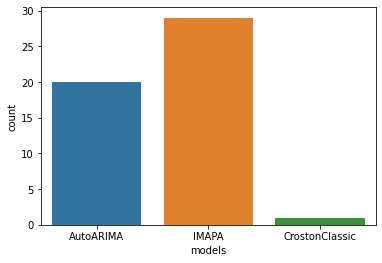

In [45]:
%%fsql
results = LOAD '{{WORKING_DIR}}/model_search.parquet'

TAKE 1 ROW PREPARTITION BY unique_id PRESORT metric ASC
OUTPUT USING plotter